# Tutorial 2: Dynamic Career Choice with Bayesian Learning

**Econometrics II - Structural Estimation**  
*Solution Version - Last Updated: 2024-10-29*

---

### Navigation
- [Model Setting](#setting)
- [Example: Two-period Model](#t2)
- [General T Periods](#general)
- [Estimation and Inference](#estimation)

In [13]:
# Setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import beta, binom, norm, chi2
from dataclasses import dataclass
from typing import Tuple, Dict, List
from math import log, sqrt

# Display settings
np.set_printoptions(suppress=True, linewidth=120, precision=4)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10


In [14]:
# Default Parameters
gamma_0 = 3.0   # Beta prior shape parameter ("prior successes")
delta_0 = 2.0   # Beta prior shape parameter ("prior failures")
w_true = 0.55   # Outside wage (true value for data generation)
beta = 0.96    # Discount factor

# Simulation settings
N_agents_default = 20000
seed_default = 123
rng = np.random.default_rng(seed_default)

print(f"Default Parameters:")
print(f"  Prior: Beta({gamma_0}, {delta_0})")
print(f"  Mean ability E[\\xi] = {gamma_0/(gamma_0+delta_0):.4f}")
print(f"  Outside wage w = {w_true}")
print(f"  Discount factor beta = {beta}")

Default Parameters:
  Prior: Beta(3.0, 2.0)
  Mean ability E[\xi] = 0.6000
  Outside wage w = 0.55
  Discount factor beta = 0.96


---
## 1. [Model Setting](#setting)<a name="setting"></a>

We study a **finite-horizon dynamic programming model** where an inventor faces an unknown success probability $\xi$ and must choose between:
- **Inventing** ($d=1$): Explore/exploit technology with Bernoulli($\xi$) success, earning 1 if successful
- **Outside option** ($d=0$): Take a safe wage $w$

### 1.1. Model Components

**Time and Decisions:**
- Time horizon: $t=1,\ldots,T$ where $T < \infty$
- Choice variable each period: $d_t \in \{0, 1\}$
  - $d_t = 0$: Take outside wage $w$ (certain payoff)
  - $d_t = 1$: Attempt invention

**Invention Outcomes:**
- If inventing: $x_t \sim \text{Bernoulli}(\xi)$
  - Success ($x_t = 1$): Earn payoff of 1 in period $t$
  - Failure ($x_t = 0$): Earn 0 in period $t$

**Ability and Learning:**
- Unknown ability: $\xi \sim \beta(\gamma_0, \delta_0)$ drawn once at beginning
- Agent doesn't know $xi$ but knows the prior distribution
- **Bayesian Learning:** Updates beliefs about $xi$ using Beta-Bernoulli conjugacy
  - Prior: $\xi \sim \beta(\gamma_0, \delta_0)$
  - After $s$ successes and $f$ failures: $\xi \sim \beta(\gamma_0+s, \delta_0+f)$
  - Success: $(\gamma, \delta) \rightarrow (\gamma+1, \delta)$
  - Failure: $(\gamma, \delta) \rightarrow (\gamma, \delta+1)$

**Preferences:**
- Lifetime utility: $\sum_{t=1}^{T} \beta^{t-1} [d_t\cdot x_t + (1-d_t)\cdot w]$
- Discount factor: $\beta \in (0,1)$
- **Implied assumption:** Risk-neutral agent (expected payoff maximizer)

---

### 1.2. Key Insight: Beta-Bernoulli Conjugacy

The Beta distribution is a **conjugate prior** for the Bernoulli likelihood:
- Prior: $g(\xi; \gamma, \delta) = \frac{\xi^{\gamma-1}(1-\xi)^{\delta-1}}{B(\gamma,\delta)}$ where $B(\gamma, \delta) = \int_0^1 u^{\gamma-1}(1-u)^{\delta-1}du$
- Likelihood: $f(x|\xi) = \xi^x(1-\xi)^{1-x}$
- Posterior: $f(\xi|x) = \frac{\xi^{\gamma+x-1}(1-\xi)^{\delta+(1-x)-1}}{B(\gamma+x, \delta+(1-x))}$

This means the posterior is also Beta distributed with updated parameters:
$$\xi | x \sim \beta(\gamma + x, \delta + (1-x))$$

**Intuition:** Think of $\gamma$ as "prior successes" and $\delta$ as "prior failures". Each new observation updates the count.

**Expected success probability:**
$$\mathbb{E}[\xi | \gamma, \delta] = \frac{\gamma}{\gamma + \delta}$$

After observing outcome $x$:
$$\mathbb{E}[\xi | \gamma', \delta'] = \begin{cases}
\frac{\gamma}{\gamma + (\delta+1)} & \text{if } x=0 \text{ (failure)} \\
\frac{\gamma+1}{(\gamma+1) + \delta} & \text{if } x=1 \text{ (success)}
\end{cases}$$


---
## 2. [Example: Two-period Model](#t2)<a name="t2"></a>

### 2.1. Benchmark: Static Problem
Let's start with a simple setting. Let suppose that we are solving a static model. In this case the lifetime utility is

$$d_t\mathbf{1} \{x_t=1\} + (1-d_t)w$$

If we knew the **exact value** of $\xi$, then the decision rule is simple: we choose to invent if the expected payoff of invention is larger than the payoff of the outside option given $\xi$:
$$
\mathbb{E}_{x}\big[1\cdot\mathbf{1}\{x=1\}+0\cdot\mathbf{1}\{x=0\}|\xi]=1\cdot\mathbb{P}(x=1|\xi) + 0\cdot\mathbb{P}(x=0|\xi) = \xi.
$$
In this case, the decision rule would be:
$$d_t=\begin{cases} 1 &\text{ if } \xi>w \\
0  &\text{ otherwise } \end{cases}$$

However, the agent only knows that her ability $\xi$ is a random draw from a beta distribution $\beta(\gamma,\delta)$, not its exact value. As a risk-neutral agent, the agent would compute her expected return on inventing and decide whether it is worth trying or not.
$$
\mathbb{E}_{\xi} \Big[\mathbb{E}_{x} \big[ \mathbf{1}\{x=1\} \big| \xi \big] \Big|\gamma,\delta\Big] =\mathbb{E}_{\xi} \big[1 \cdot \mathbb{P}(x=1|\xi) + 0 \cdot \mathbb{P}(x=0|\xi) \big| \gamma,\delta \big] =\mathbb{E}_{\xi} [1 \cdot \xi + 0 \cdot (1-\xi) | \gamma,\delta] = \mathbb{E}_{\xi}[{\xi}|\gamma,\delta]=\frac{\gamma}{\gamma+\delta}.
$$

The decision rule is then:
$$
d_t=\begin{cases} 1 &\text{ if } \frac{\gamma}{\gamma+\delta}>w \\
0  &\text{ otherwise } \end{cases}
$$

By now, you might have noticed that in the static case, everyone makes the same choice! This is because in the first period, everyone has the same belief about their ability. As agents try out inventing and finds more about their ability, we will see that people making different choices.

**Remark**:
Given the data where everyone making the same choice (i.e., all zeros or all ones), we cannot point-identify **any** parameter of the set of parameters $(\gamma,\delta,w)$. Let's take a step back and look at the decision rule:
$$
d_t=\begin{cases} 1 &\text{ if } \frac{\gamma}{\gamma+\delta}>w \\
0  &\text{ otherwise } \end{cases}
$$

- If we are given the true value of one of $(\gamma,\delta,w)$, can you find the exact values for the rest of parameters? No.
  - For example, let's say we are given $w=42$. What are the values of $\gamma$ and $\delta$ that can generate the data we have? All $(\gamma,\delta)$ that satisfy $\frac{\gamma}{\gamma+\delta}>42$.
  - Since we have only one inequality and two parameters, we cannot point-identify $\gamma$ and $\delta$.
- What if we are given two parameter values from $(\gamma,\delta,w)$? Can we point-identify the only left parameter?
  - Again, as we are given an inequality, we can only find some bounds on the parameter we wish to identify.
  - For example, if we are given $\gamma=3$ and $\delta=1$, then any $w$ that satisfies $\frac{\gamma}{\gamma+\delta}=\frac{3}{4}>w$ can generate the same data.

**Key Takeaway**: We need more than two periods to see any variation in our data to pin down our unknown parameters ($\gamma$, $\delta$, $w$) from data on agent's decisions.

---
### 2.2. Optimal Decision
Let's thoroughly analyze the **two-period model** to build intuition before tackling the general case.

**Lifetime utility with T=2:**
$$U = d_1\cdot x_1 + (1-d_1)\cdot w + \beta[d_2\cdot x_2 + (1-d_2)\cdot w]$$

State variables in each period: $(\gamma_t, \delta_t, w, t, \beta)$

#### 2.2.1. Solving by Backward Induction -- Period 2: Terminal Decision

At $t=2$ (the final period), the agent observes state $(\gamma_2, \delta_2)$ and solves:
$$
\max_{d_2 \in \{0,1\}} \mathbb{E}_{\xi_2}\left[\mathbb{E}_{x_2}\left[d_2\cdot\mathbf{1}\{x_2=1\} + (1-d_2)\cdot w \mid \xi_2\right] \mid \gamma_2, \delta_2\right] =
\begin{cases}
\frac{\gamma_2}{\gamma_2+\delta_2} & \text{ if }d_2 = 1 \\
w & \text{ otherwise}
\end{cases} \\
$$

Since this is the **terminal period** (no future to consider), the decision is straightforward:
- **Expected payoff from inventing:** $\mathbb{E}[\mathbf{1}\{x_2=1\} | \gamma_2, \delta_2] = \frac{\gamma_2}{\gamma_2 + \delta_2}$
- **Payoff from outside option:** $w$

**Decision rule at t=2:**
$$d_2(\gamma_2, \delta_2, w) = \mathbf{1}\left\{\frac{\gamma_2}{\gamma_2 + \delta_2} > w\right\}$$

**Value function at t=2:**
$$V(\gamma_2, \delta_2, w, 2, \beta) = \max\left\{\frac{\gamma_2}{\gamma_2 + \delta_2}, w\right\}$$


#### 2.2.2. Solving by Backward Induction -- Period 1: Forward-Looking Decision

At $t=1$, the agent must consider:
1. **Immediate payoff** (just like period 2)
2. **Information value** of learning about $\xi$ for use in period 2

**Value function at t=1:**
$$
\begin{align*}
    V(\gamma_1,\delta_1,w,1,\beta) = \underset{d_{1}\in\{0,1\}}{\max}\; \mathbb{E}_{\xi_1}\Big[&\mathbb{E}_{x_1}[d_1\mathbf{1}\{x_{1}=1\}+(1-d_{1})w|\xi_1\big]\Big|\gamma_1,\delta_1\Big] \\
    +\beta \Bigg(&d_1\mathbb{E}_{\xi_1}\Big[\mathbb{E}_{x_1}\Big[\mathbf{1}\{x_1=0|\gamma_1,\delta_1\}V(\gamma_2,\delta_2,w,2,\beta)\Big|\xi_1\Big]\Big|\gamma_1,\delta_1\Big]+\\
                 &d_1\mathbb{E}_{\xi_1}\Big[\mathbb{E}_{x_1}\Big[\mathbf{1}\{x_1=1|\gamma_1,\delta_1\}V(\gamma_2,\delta_2,w,2,\beta)\Big|\xi_1\Big]\Big|\gamma_1,\delta_1\Big]+\\
                 &(1-d_1)V(\gamma_2,\delta_2,w,2,\beta)\Bigg)
\end{align*}
$$

where $(\gamma_2, \delta_2)$ are updated based on the outcome at $t=1$:
$$
(\gamma_2, \delta_2) = \begin{cases}
(\gamma_1 + 1, \delta_1) & \text{if } x_1 = 1 \text{ (success)} \\
(\gamma_1, \delta_1 + 1) & \text{if } x_1 = 0 \text{ (failure)} \\
(\gamma_1, \delta_1) & \text{if } d_1 = 0 \text{ (didn't invent)}
\end{cases}
$$

#### 2.2.3. Mort Explicit Representation -- Comparing the Two Options at t=1

Let's denote:
- $p_1 = \frac{\gamma_1}{\gamma_1 + \delta_1}$ = current expected success probability
- $p_1^s = \frac{\gamma_1 + 1}{\gamma_1 + \delta_1 + 1}$ = posterior mean after success
- $p_1^f = \frac{\gamma_1}{\gamma_1 + \delta_1 + 1}$ = posterior mean after failure

Note that $p_1^f < p_1 < p_1^s$ (failure lowers belief, success raises it).

**Option A: Take outside option at t=1**
$$V^0_1 = w + \beta \cdot V_2(\gamma_1, \delta_1)$$
- Get wage $w$ now
- At $t=2$, beliefs are unchanged $(\gamma_1, \delta_1)$

**Option B: Invent at t=1**
$$V^1_1 = p_1 + \beta \cdot [p_1 \cdot V_2(\gamma_1+1, \delta_1) + (1-p_1) \cdot V_2(\gamma_1, \delta_1+1)]$$
- Get expected payoff $p_1$ now
- With probability $p_1$: succeed, update to $(\gamma_1+1, \delta_1)$
- With probability $1-p_1$: fail, update to $(\gamma_1, \delta_1+1)$
- At $t=2$, make decision with updated beliefs

**Key insight:** The invention option has an **information option value**. Even if $p_1 \approx w$ (so immediate payoffs are similar), inventing might be better because it generates information that improves period 2 decisions.

#### 2.2.4. Closed-Form Analysis for T=2

With $T=2$, we can derive explicit expressions. Let's assume everyone invents at $t=1$ (we'll verify this holds for our parameters).

**The Quit Hazard at t=2:**

The hazard $h_2$ is the fraction of agents (who invented at $t=1$) that quit at $t=2$, $Pr[d_2=0|d_1=1]$.

Starting from $(\gamma_1, \delta_1)$ at $t=1$:
- With probability $p_1 = \frac{\gamma_1}{\gamma_1+\delta_1}$: Success → update to $(\gamma_1+1, \delta_1)$
  - At $t=2$: Quit if $p_1^s \equiv \frac{\gamma_1+1}{\gamma_1+\delta_1+1} < w$
- With probability $1-p_1 = \frac{\delta_1}{\gamma_1+\delta_1}$: Failure → update to $(\gamma_1, \delta_1+1)$
  - At $t=2$: Quit if $p_1^f \equiv \frac{\gamma_1}{\gamma_1+\delta_1+1} < w$

**Hazard formula:**
$$h_2(w) = p_1 \cdot \mathbf{1}\left\{p_1^s < w\right\} + (1-p_1) \cdot \mathbf{1}\left\{p_1^f < w\right\}$$

This is a **step function** with three regions:

1. **Region 1:** $w \leq p_1^f$ → Both success and failure types continue → $h_2 = 0$
2. **Region 2:** $p_1^f < w < p_1^s$ → Only failures quit → $h_2 = 1-p_1 = \frac{\delta_1}{\gamma_1+\delta_1}$
3. **Region 3:** $w \geq p_1^s$ → Everyone quits → $h_2 = 1$

In [15]:
# Compute T=2 threshold values
def compute_t2_thresholds(gamma, delta):
    """Compute the threshold wages for T=2 model"""
    p1 = gamma / (gamma + delta)
    p1_fail = gamma / (gamma + delta + 1)
    p1_succ = (gamma + 1) / (gamma + delta + 1)
    h2_middle = delta / (gamma + delta)
    
    return {
        'p1': p1,
        'p1_fail': p1_fail,
        'p1_succ': p1_succ,
        'h2_middle': h2_middle
    }

# Compute for default parameters
thresholds = compute_t2_thresholds(gamma_0, delta_0)

print("="*80)
print("T=2 THEORETICAL ANALYSIS")
print("="*80)
print(f"\nPrior: Beta({gamma_0}, {delta_0})")
print(f"  Prior mean: $p_1$ = {thresholds['p1']:.4f}")
print(f"\nPosterior means at t=2:")
print(f"  After failure: $p_1^f$ = {thresholds['p1_fail']:.4f}")
print(f"  After success: $p_1^s$ = {thresholds['p1_succ']:.4f}")
print(f"\nHazard function $h_2(w)$:")
print(f"  Region 1: w ≤ {thresholds['p1_fail']:.4f}  →  $h_2$ = 0.0000 (no one quits)")
print(f"  Region 2: {thresholds['p1_fail']:.4f} < w < {thresholds['p1_succ']:.4f}  →  $h_2$ = {thresholds['h2_middle']:.4f} (failures quit)")
print(f"  Region 3: w ≥ {thresholds['p1_succ']:.4f}  →  $h_2$ = 1.0000 (everyone quits)")
print(f"\nWith w_true = {w_true}:")
print(f"  w is in Region 2: {thresholds['p1_fail']:.4f} < {w_true} < {thresholds['p1_succ']:.4f}")
print(f"  Expected $h_2$ ≈ {thresholds['h2_middle']:.4f}")

T=2 THEORETICAL ANALYSIS

Prior: Beta(3.0, 2.0)
  Prior mean: $p_1$ = 0.6000

Posterior means at t=2:
  After failure: $p_1^f$ = 0.5000
  After success: $p_1^s$ = 0.6667

Hazard function $h_2(w)$:
  Region 1: w ≤ 0.5000  →  $h_2$ = 0.0000 (no one quits)
  Region 2: 0.5000 < w < 0.6667  →  $h_2$ = 0.4000 (failures quit)
  Region 3: w ≥ 0.6667  →  $h_2$ = 1.0000 (everyone quits)

With w_true = 0.55:
  w is in Region 2: 0.5000 < 0.55 < 0.6667
  Expected $h_2$ ≈ 0.4000


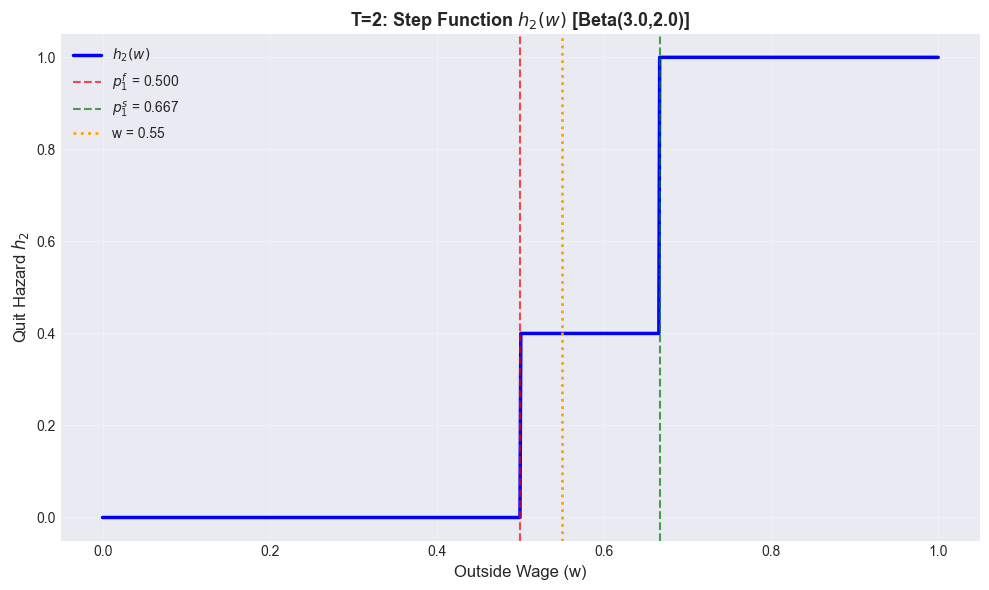

In [16]:
# Visualize the step function
def plot_h2_step_function(gamma, delta, w_true_val=None):
    """Plot the theoretical step function h2(w)"""
    th = compute_t2_thresholds(gamma, delta)
    
    w_grid = np.linspace(0, 1, 1000)
    h2_theory = np.zeros_like(w_grid)
    
    # Step function
    h2_theory[w_grid <= th['p1_fail']] = 0.0
    h2_theory[(w_grid > th['p1_fail']) & (w_grid < th['p1_succ'])] = th['h2_middle']
    h2_theory[w_grid >= th['p1_succ']] = 1.0
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(w_grid, h2_theory, 'b-', linewidth=2.5, label='$h_2(w)$')
    ax.axvline(th['p1_fail'], color='red', linestyle='--', alpha=0.7, 
               label=f"$p_1^f$ = {th['p1_fail']:.3f}")
    ax.axvline(th['p1_succ'], color='green', linestyle='--', alpha=0.7, 
               label=f"$p_1^s$ = {th['p1_succ']:.3f}")
    
    if w_true_val:
        ax.axvline(w_true_val, color='orange', linestyle=':', linewidth=2, 
                   label=f'w = {w_true_val}')
    
    ax.set_xlabel('Outside Wage (w)', fontsize=12)
    ax.set_ylabel('Quit Hazard $h_2$', fontsize=12)
    ax.set_title(f'T=2: Step Function $h_2(w)$ [Beta({gamma},{delta})]',
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()

plot_h2_step_function(gamma_0, delta_0, w_true)

---
### 2.3. Identification

**The Fundamental Problem:**

With $T=2$, we observe a single hazard $h_2$. From the step function above:
- If $h_2 \approx 0$: We know $w \leq p_1^f$, but not the exact value
- If $h_2 \approx \frac{\delta_1}{\gamma_1+\delta_1}$: We know $p_1^f < w < p_1^s$ (an interval!)
- If $h_2 \approx 1$: We know $w \geq p_1^s$, but not the exact value

This is **set identification**, not point identification.

**Why does this happen?**
- The hazard $h_2(w)$ is constant within each region
- Fisher information: $I(w) \propto [h_2'(w)]^2 = 0$ almost everywhere
- Standard MLE asymptotics break down

**What helps identification:**
1. Longer time horizons ($T > 2$) give more variation
2. Additional data on outcomes (not just quit decisions)
3. Known values of some parameters $(\gamma_1, \delta_1, \beta)$


#### 2.3.1. Question 1

Prove that it is never optimal to do something else in any period $t$ and invent in period $t + 1$. Thus, the optimal career strategy is to spend no periods inventing, or spend one or more periods inventing at the beginning of your career.

WRITE YOUR ANSWER HERE

#### 2.3.2. Question 2

Let's consider $T = 2$ case. Can you explain why not all the parameters in your model are identified from the solution to the quit rates without imposing restrictions (such as knowing the values of some of the parameters)?

WRITE YOUR ANSWER HERE

---
### 2.4. Data / Simulation

Let's verify our theoretical predictions by simulation.

In [17]:
# Simple T=2 simulation
def simulate_t2_simple(gamma, delta, w, N, seed=0):
    """
    Simulate T=2 model and compute h2.
    Assumes everyone invents at t=1.
    """
    rng_local = np.random.default_rng(seed)
    
    # Draw abilities (fixed for each agent)
    θ = rng_local.beta(gamma, delta, size=N)
    
    # Period 1: Everyone invents, observe outcome
    x1 = rng_local.binomial(1, θ)
    
    # Update beliefs based on x1
    gamma_2 = gamma + x1
    delta_2 = delta + (1 - x1)
    
    # Period 2: Decide based on updated beliefs
    p2 = gamma_2 / (gamma_2 + delta_2)
    d2 = (p2 >= w).astype(int)
    
    # Hazard = fraction who quit (d2=0)
    h2_simulated = 1 - d2.mean()
    
    return h2_simulated, d2

# Simulate
h2_sim, d2_data = simulate_t2_simple(gamma_0, delta_0, w_true, N_agents_default, seed=123)

print("\nT=2 Simulation Results:")
print(f"  Theoretical h₂ = {thresholds['h2_middle']:.4f}")
print(f"  Simulated h₂   = {h2_sim:.4f}")
print(f"  Difference     = {abs(h2_sim - thresholds['h2_middle']):.4f}")
print(f"  N = {N_agents_default:,} agents")



T=2 Simulation Results:
  Theoretical h₂ = 0.4000
  Simulated h₂   = 0.4015
  Difference     = 0.0015
  N = 20,000 agents


---
### 2.5. Economic Interpretation

**What have we learned?**

1. **Learning creates heterogeneity:** Even though all agents start with the same beliefs $(\gamma_0, \delta_0)$, after one period they have different beliefs depending on their experience.

2. **Selection matters:** At $t=2$, we observe only those with favorable beliefs continuing to invent. Those who failed at $t=1$ have lower beliefs and are more likely to quit.

3. **Limited information from short panels:** With just $T=2$ periods, we can't precisely pin down parameters. The hazard is too coarse.

4. **Option value of experimentation:** The decision to invent at $t=1$ isn't just about immediate payoff $p_1$ vs $w$. It's also about learning $\xi$ to make a better decision at $t=2$.

**Extension to longer horizons:**
With $T > 2$, we get:
- More periods of learning and selection
- Richer variation in hazards $h_2, h_3, \ldots, h_T$
- Better parameter identification
- More complex dynamics (beliefs evolve along different paths)

---

## 3. [General T Periods](#general)<a name="general"></a>

Now that we understand the T=2 case thoroughly, let's implement the general solution for any $T$.

### 3.1. Backward Induction Algorithm with Forward Time Indexing

The key insight from T=2 generalizes: we solve **backward** from $t=T$ to $t=1$.
- $t=1, 2, \ldots, T$ represents chronological time (later periods have higher indices)
- $V_t(\gamma, \delta)$ = value function at period $t$ (with $T-t+1$ periods remaining)
- $V_{t+1}(\gamma, \delta)$ = continuation value in the **next period** chronologically

**(1) State space:** $(\gamma, \delta, t)$ where
- $\gamma, \delta$: Current Beta parameters (belief state)
- $t$: Current period (1, 2, ..., T)

**(2) Bellman equation for $t = 1, \ldots, T$:**
$$V_t(\gamma, \delta) = \max\{V_t^0(\gamma, \delta), V_t^1(\gamma, \delta)\}$$

where:
- **Outside option:** $V_t^0(\gamma, \delta) = w + \beta \cdot V_{t+1}(\gamma, \delta)$
- **Invention:** $V_t^1(\gamma, \delta) = p + \beta \cdot [p \cdot V_{t+1}(\gamma+1, \delta) + (1-p) \cdot V_{t+1}(\gamma, \delta+1)]$

with $p = \frac{\gamma}{\gamma+\delta}$.

**Terminal condition:** $V_{T}(\gamma, \delta) = 0$ for all $(\gamma, \delta)$.

**(3) Policy function:**
$$d_t^*(\gamma, \delta) = \mathbf{1}\{V_t^1(\gamma, \delta) \geq V_t^0(\gamma, \delta)\}$$

### 3.2. Unified Simulator Class

We now create a **unified class** that encapsulates all model components:
- Prior beliefs and utility parameters
- Utility functions (immediate payoffs)
- Value functions (from backward induction)
- Decision rules (policies)
- Agent simulation and hazard computation

This makes the relationships between components explicit and easier to understand.

#### Function-Component Mapping

The `BayesianLearningModel` class is organized into 6 logical sections:

**1. UTILITY FUNCTIONS (Section 1)**
- `expected_success_prob(gamma, delta)`: Computes $\mathbb{E}[\xi|\gamma,\delta] = \frac{\gamma}{\gamma+\delta}$
- `immediate_payoff_invent(gamma, delta)`: Returns expected payoff from inventing this period
- `immediate_payoff_outside()`: Returns certain payoff $w$ from outside option

**2. BELIEF UPDATING (Section 2)**
- `update_beliefs(gamma, delta, outcome)`: Implements Beta-Bernoulli conjugacy
  - Success (outcome=1): $(\gamma, \delta) \rightarrow (\gamma+1, \delta)$
  - Failure (outcome=0): $(\gamma, \delta) \rightarrow (\gamma, \delta+1)$

**3. VALUE FUNCTIONS (Section 3)**
- `solve()`: Main solver using backward induction to fill `self.V` and `self.D` dictionaries
  - Creates value function grid `V[t][ia, ib]` for each period $t$
  - Creates decision rule grid `D[t][ia, ib]` for each period $t$
- `value_outside_option(gamma, delta, t)`: Computes $V^0_t = w + \beta V_{t+1}(\gamma, \delta)$
- `value_invent(gamma, delta, t)`: Computes $V^1_t = p + \beta[pV_{t+1}(\gamma+1,\delta) + (1-p)V_{t+1}(\gamma,\delta+1)]$

**4. DECISION RULES (Section 4)**
- `get_decision(gamma, delta, t)`: Returns optimal choice (0 or 1) from solved policy
- `get_value(gamma, delta, t)`: Returns value function at given state

**5. AGENT SIMULATION (Section 5)**
- `simulate(N, seed, return_paths)`: Forward simulates N agents through T periods
  - Draws abilities $\xi_i \sim Beta(\gamma_0, \delta_0)$ for each agent
  - Follows optimal policies `D[t]` at each period
  - Computes hazard rates $h_t$ = fraction quitting at period $t$
  - Optionally returns full decision/outcome paths

**6. SUMMARY AND DIAGNOSTICS (Section 6)**
- `summary()`: Prints model parameters and solution status
- `get_hazard_at_t(t)`, `get_value_at_t(t)`, `get_decision_at_t(t)`: Accessor methods

**Usage Flow:**
1. Create `ModelParameters` with $(\gamma_0, \delta_0, w, \beta, T)$
2. Instantiate `BayesianLearningModel(params)`
3. Call `.solve()` to run backward induction (fills V and D)
4. Call `.simulate(N)` to generate data and compute hazards
5. Use `.summary()` and accessor methods to inspect results

In [18]:
# ============================================================================
# Unified Bayesian Learning Model
# ============================================================================

@dataclass
class ModelParameters:
    """Container for all model parameters"""
    gamma_0: float  # Prior successes
    delta_0: float  # Prior failures
    w: float        # Outside wage
    beta: float     # Discount factor
    T: int          # Time horizon

    def prior_mean(self) -> float:
        """Expected ability under prior"""
        return self.gamma_0 / (self.gamma_0 + self.delta_0)

    def __repr__(self):
        return (f"ModelParameters(gamma_0={self.gamma_0}, delta_0={self.delta_0}, "
                f"w={self.w}, beta={self.beta}, T={self.T})")


class BayesianLearningModel:
    """
    Unified class for Bayesian learning career choice model.
    
    USES FORWARD TIME INDEXING: t=1,2,...,T where higher t = later chronological period
    V[t] = value function at period t
    V[t+1] = continuation value in next period

    Components:
    -----------
    1. Parameters: gamma_0, delta_0, w, beta, T
    2. Utility functions: immediate payoffs from each choice
    3. Belief updating: Beta-Bernoulli conjugacy
    4. Value functions: Solved via backward induction
    5. Decision rules: Optimal policies at each state
    6. Simulation: Generate panel data and compute hazards
    7. Visualization: Plot value/policy functions and hazard rates

    Usage:
    ------
    >>> params = ModelParameters(gamma_0=3, delta_0=2, w=0.55, beta=0.96, T=5)
    >>> model = BayesianLearningModel(params)
    >>> model.solve()
    >>> hazards = model.simulate(N=10000, seed=42)
    >>> model.plot_value_and_policy(t=1)
    >>> model.plot_hazards()
    """

    def __init__(self, params: ModelParameters):
        self.params = params
        self.V = None  # Value functions
        self.D = None  # Decision rules
        self.hazards = None     # Hazard rates
        self.is_solved = False

        # Grid setup
        self.gamma_base = int(np.floor(params.gamma_0))
        self.delta_base = int(np.floor(params.delta_0))
        self.A = self.gamma_base + params.T + 1  # Grid size gamma dimension
        self.B = self.delta_base + params.T + 1  # Grid size delta dimension

    # ========================================================================
    # 1. UTILITY FUNCTIONS
    # ========================================================================

    def expected_success_prob(self, gamma: float, delta: float) -> float:
        """
        Expected success probability given beliefs.
        E[xi | gamma, delta] = gamma / (gamma + delta)
        """
        return gamma / (gamma + delta)

    def immediate_payoff_invent(self, gamma: float, delta: float) -> float:
        """Immediate expected payoff from inventing"""
        return self.expected_success_prob(gamma, delta)

    def immediate_payoff_outside(self) -> float:
        """Immediate payoff from outside option"""
        return self.params.w

    # ========================================================================
    # 2. BELIEF UPDATING
    # ========================================================================

    def update_beliefs(self, gamma: float, delta: float,
                       outcome: int) -> Tuple[float, float]:
        """
        Update Beta beliefs based on outcome.

        Parameters:
        -----------
        gamma, delta : current belief parameters
        outcome : 1 if success, 0 if failure

        Returns:
        --------
        (gamma_new, delta_new) : updated beliefs
        """
        if outcome == 1:  # Success
            return gamma + 1, delta
        else:  # Failure
            return gamma, delta + 1

    # ========================================================================
    # 3. VALUE FUNCTIONS
    # ========================================================================

    def value_outside_option(self, gamma: float, delta: float,
                            t: int) -> float:
        """
        Value of choosing outside option at state (gamma, delta, t).
        V^0_t = w + beta * V_{t+1}(gamma, delta)
        """
        if not self.is_solved:
            raise ValueError("Model not solved. Call solve() first.")

        ia = int(gamma) - self.gamma_base
        ib = int(delta) - self.delta_base

        # Immediate payoff + continuation value (no belief update)
        immediate = self.immediate_payoff_outside()
        continuation = self.params.beta * self.V[t+1][ia, ib] if t <= self.params.T else 0

        return immediate + continuation

    def value_invent(self, gamma: float, delta: float, t: int) -> float:
        """
        Value of inventing at state (gamma, delta, t).
        V^1_t = p + beta * [p*V_{t+1}(gamma+1,delta) + (1-p)*V_{t+1}(gamma,delta+1)]
        """
        if not self.is_solved:
            raise ValueError("Model not solved. Call solve() first.")

        ia = int(gamma) - self.gamma_base
        ib = int(delta) - self.delta_base
        p = self.expected_success_prob(gamma, delta)

        # Immediate expected payoff
        immediate = self.immediate_payoff_invent(gamma, delta)

        # Continuation value (expected over outcomes)
        if t <= self.params.T:
            ia_succ = min(ia + 1, self.A - 1)
            ib_fail = min(ib + 1, self.B - 1)
            continuation = self.params.beta * (
                p * self.V[t+1][ia_succ, ib] +      # Success path
                (1-p) * self.V[t+1][ia, ib_fail]    # Failure path
            )
        else:  # t > T case
            continuation = 0

        return immediate + continuation

    def solve(self, verbose: bool = False) -> 'BayesianLearningModel':
        """
        Solve the dynamic programming problem via backward induction.
        Uses FORWARD TIME INDEXING: t=1,2,...,T

        Fills in:
        - self.V: Dict[int, np.ndarray] - value functions V[t][gamma_idx, delta_idx]
        - self.D: Dict[int, np.ndarray] - decision rules D[t][gamma_idx, delta_idx]

        Returns self for method chaining.
        """
        T = self.params.T
        self.V = {T+1: np.zeros((self.A, self.B))}  # Terminal condition at T+1
        self.D = {}

        if verbose:
            print(f"Solving DP with T={T}, grid size ({self.A}, {self.B})...")

        # Backward induction from t=T down to t=1
        for t in range(T, 0, -1):
            V_t = np.zeros((self.A, self.B))
            D_t = np.zeros((self.A, self.B), dtype=int)

            for ia in range(self.A):
                for ib in range(self.B):
                    gamma = self.gamma_base + ia
                    delta = self.delta_base + ib
                    p = self.expected_success_prob(gamma, delta)

                    # Compute value of each option
                    V0 = self.params.w + self.params.beta * self.V[t+1][ia, ib]

                    ia_plus = min(ia + 1, self.A - 1)
                    ib_plus = min(ib + 1, self.B - 1)
                    V1 = p + self.params.beta * (
                        p * self.V[t+1][ia_plus, ib] +
                        (1-p) * self.V[t+1][ia, ib_plus]
                    )

                    # Optimal decision
                    if V1 >= V0:
                        V_t[ia, ib] = V1
                        D_t[ia, ib] = 1  # Invent
                    else:
                        V_t[ia, ib] = V0
                        D_t[ia, ib] = 0  # Outside option

            self.V[t] = V_t
            self.D[t] = D_t

            if verbose and t in [1, T//2, T]:
                ia0 = int(np.floor(self.params.gamma_0)) - self.gamma_base
                ib0 = int(np.floor(self.params.delta_0)) - self.delta_base
                print(f"  t={t}: V={V_t[ia0,ib0]:.4f}, D={D_t[ia0,ib0]}")

        self.is_solved = True
        return self

    # ========================================================================
    # 4. DECISION RULES
    # ========================================================================

    def get_decision(self, gamma: float, delta: float, t: int) -> int:
        """
        Get optimal decision at state (gamma, delta, t).

        Returns:
        --------
        0 for outside option, 1 for invent
        """
        if not self.is_solved:
            raise ValueError("Model not solved. Call solve() first.")

        ia = int(gamma) - self.gamma_base
        ib = int(delta) - self.delta_base
        return self.D[t][ia, ib]

    def get_value(self, gamma: float, delta: float, t: int) -> float:
        """Get value function at state (gamma, delta, t)"""
        if not self.is_solved:
            raise ValueError("Model not solved. Call solve() first.")

        ia = int(gamma) - self.gamma_base
        ib = int(delta) - self.delta_base
        return self.V[t][ia, ib]

    # ========================================================================
    # 5. AGENT SIMULATION
    # ========================================================================

    def simulate(self, N: int, seed: int = 0,
                return_paths: bool = False) -> Dict[int, float]:
        """
        Simulate N agents through the model.
        Uses FORWARD TIME: t=1,2,...,T

        Parameters:
        -----------
        N : int
            Number of agents to simulate
        seed : int
            Random seed
        return_paths : bool
            If True, return full paths in addition to hazards

        Returns:
        --------
        hazards : Dict[int, float]
            Quit hazards by period h_t = P(quit at t | active at t)

        If return_paths=True, also returns:
        paths : Dict with arrays of agent histories
        """
        if not self.is_solved:
            raise ValueError("Model not solved. Call solve() first.")

        rng_local = np.random.default_rng(seed)
        T = self.params.T

        # Draw abilities (fixed for each agent)
        xi = rng_local.beta(self.params.gamma_0, self.params.delta_0, size=N)

        # Initialize belief states (index form)
        ia = np.full(N, int(np.floor(self.params.gamma_0)) - self.gamma_base, dtype=int)
        ib = np.full(N, int(np.floor(self.params.delta_0)) - self.delta_base, dtype=int)

        # Track active agents
        active = np.ones(N, dtype=bool)

        # Storage
        self.hazards = {}
        paths = {'decisions': [], 'outcomes': [], 'beliefs': []} if return_paths else None

        # Forward simulation: t=1,2,...,T
        for t in range(1, T + 1):
            # Get decisions from policy
            D_t = self.D[t]
            decisions = D_t[ia, ib]

            # Compute hazard
            at_risk = active.copy()
            if at_risk.sum() > 0:
                quits = ((decisions == 0) & at_risk)
                self.hazards[t] = quits.sum() / at_risk.sum()
            else:
                self.hazards[t] = np.nan

            # Update active status
            inventors = (decisions == 1) & at_risk
            active = inventors.copy()

            # Draw outcomes for inventors and update beliefs
            if inventors.any():
                rng_period = np.random.default_rng(seed + t)
                outcomes = rng_period.binomial(1, xi[inventors])

                # Update belief indices
                ia_inv = ia[inventors]
                ib_inv = ib[inventors]
                ia_new = np.minimum(ia_inv + outcomes, self.A - 1)
                ib_new = np.minimum(ib_inv + (1 - outcomes), self.B - 1)
                ia[inventors] = ia_new
                ib[inventors] = ib_new

                if return_paths:
                    paths['decisions'].append(decisions.copy())
                    paths['outcomes'].append(outcomes.copy())
                    paths['beliefs'].append((ia.copy(), ib.copy()))

        if return_paths:
            return self.hazards, paths
        return self.hazards

    # ========================================================================
    # 6. VISUALIZATION
    # ========================================================================
    
    def plot_value_and_policy(self, t: int = 1, figsize: Tuple[int, int] = (14, 5)):
        """
        Visualize policy function and value function at period t.
        
        Parameters:
        -----------
        t : int
            Period to visualize (default: t=1, initial period)
        figsize : tuple
            Figure size
        """
        if not self.is_solved:
            raise ValueError("Model must be solved first. Call solve().")
        
        # Get policy and value functions
        D_t = self.D[t]
        V_t = self.V[t]
        
        # Create meshgrid for plotting
        gamma_vec = np.arange(self.gamma_base, self.gamma_base + self.A)
        delta_vec = np.arange(self.delta_base, self.delta_base + self.B)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Policy function heatmap
        im1 = ax1.imshow(D_t, aspect='auto', origin='lower', cmap='RdYlGn', 
                          extent=[delta_vec[0]-0.5, delta_vec[-1]+0.5, 
                                 gamma_vec[0]-0.5, gamma_vec[-1]+0.5])
        ax1.set_xlabel(r'$\delta$ (Prior Failures)', fontsize=12)
        ax1.set_ylabel(r'$\gamma$ (Prior Successes)', fontsize=12)
        ax1.set_title(f'Policy Function at t={t}\n(1=Invent, 0=Outside)', 
                      fontsize=13, fontweight='bold')
        cbar1 = plt.colorbar(im1, ax=ax1)
        cbar1.set_label('Decision', fontsize=10)
        
        # Mark initial state
        ia0 = int(np.floor(self.params.gamma_0)) - self.gamma_base
        ib0 = int(np.floor(self.params.delta_0)) - self.delta_base
        ax1.plot(self.params.delta_0, self.params.gamma_0, 'r*', 
                 markersize=15, label=f'Initial state ({self.params.gamma_0},{self.params.delta_0})')
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        # Value function heatmap
        im2 = ax2.imshow(V_t, aspect='auto', origin='lower', cmap='viridis',
                          extent=[delta_vec[0]-0.5, delta_vec[-1]+0.5, 
                                 gamma_vec[0]-0.5, gamma_vec[-1]+0.5])
        ax2.set_xlabel(r'$\delta$ (Prior Failures)', fontsize=12)
        ax2.set_ylabel(r'$\gamma$ (Prior Successes)', fontsize=12)
        ax2.set_title(f'Value Function at t={t}', fontsize=13, fontweight='bold')
        cbar2 = plt.colorbar(im2, ax=ax2)
        cbar2.set_label('Value', fontsize=10)
        
        # Mark initial state
        ax2.plot(self.params.delta_0, self.params.gamma_0, 'r*', 
                 markersize=15, label=f'V={V_t[ia0, ib0]:.3f}')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()

    def plot_hazards(self, figsize: Tuple[int, int] = (14, 5)):
        """
        Plot survival rates and hazard rates over time.
        
        Parameters:
        -----------
        figsize : tuple
            Figure size
        """
        if self.hazards is None:
            raise ValueError("No hazards to plot. Call simulate() first.")
        
        T = self.params.T
        t_range = np.arange(1, T + 1)
        h_vals = np.array([self.hazards[t] for t in t_range])
        
        # Compute survival rates: S_t = (1-h_1)(1-h_2)...(1-h_t)
        survival = np.cumprod(1 - h_vals)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Survival rate plot
        ax1.plot(t_range, survival, 'b-o', linewidth=2, markersize=6)
        ax1.set_xlabel('Period t', fontsize=12)
        ax1.set_ylabel('Survival Rate', fontsize=12)
        ax1.set_title('Fraction of Agents Still Inventing at t', 
                      fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([-0.05, 1.05])
        
        # Hazard rate plot
        ax2.plot(t_range, h_vals, 'r-s', linewidth=2, markersize=6)
        ax2.set_xlabel('Period t', fontsize=12)
        ax2.set_ylabel('Hazard Rate $h_t$', fontsize=12)
        ax2.set_title(r'Quit Rate: $h_t = \mathbb{P}(d_t=0 \mid d_{t-1}=1)$', 
                      fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([-0.05, 1.05])
        
        plt.tight_layout()
        plt.show()

    # ========================================================================
    # 7. SUMMARY AND DIAGNOSTICS
    # ========================================================================

    def summary(self) -> str:
        """Return string summary of model"""
        s = "="*70 + "\n"
        s += "BAYESIAN LEARNING MODEL SUMMARY\n"
        s += "="*70 + "\n"
        s += f"\nParameters:\n"
        s += f"  Prior: Beta({self.params.gamma_0}, {self.params.delta_0})\n"
        s += f"  Prior mean ability: {self.params.prior_mean():.4f}\n"
        s += f"  Outside wage w: {self.params.w}\n"
        s += f"  Discount factor beta: {self.params.beta}\n"
        s += f"  Time horizon T: {self.params.T}\n"
        s += f"\nSolution status: {'SOLVED' if self.is_solved else 'NOT SOLVED'}\n"

        if self.is_solved:
            ia0 = int(np.floor(self.params.gamma_0)) - self.gamma_base
            ib0 = int(np.floor(self.params.delta_0)) - self.delta_base
            s += f"\nInitial state value V_1(gamma_0, delta_0) = {self.V[1][ia0, ib0]:.4f}\n"
            s += f"Initial decision D_1(gamma_0, delta_0) = {self.D[1][ia0, ib0]} "
            s += f"({'INVENT' if self.D[1][ia0, ib0] == 1 else 'OUTSIDE'})\n"

        s += "="*70
        return s

### 3.3. Example Usage for T=2 Model

**Connection to Section 2: Verifying Equivalence with Closed-Form Solution**

In Section 2, we derived the **closed-form solution** for the T=2 model analytically. Now we verify that our general `BayesianLearningModel` class (which works for any T) reproduces the same results when T=2.

**Key equivalences to verify:**
- Decision rules: Does everyone invent at t=1?
- Hazard rate: Does $h_2$ match the theoretical formula $h_2 = \frac{\delta_0}{\gamma_0+\delta_0}$?
- Value function: Does $V_1(\gamma_0, \delta_0)$ match the value we'd compute by hand?

This verification ensures our general algorithm is implemented correctly.

In [19]:
# ============================================================================
# DEMONSTRATION: T=2 Model - Equivalence with Closed-Form Solution
# ============================================================================

# Create model with T=2 using parameters defined at the top
params_t2 = ModelParameters(
    gamma_0=gamma_0,
    delta_0=delta_0,
    w=w_true,
    beta=beta,
    T=2
)

print("="*80)
print("T=2 MODEL: VERIFYING EQUIVALENCE WITH SECTION 2")
print("="*80)
print(f"\nParameters: γ={gamma_0}, δ={delta_0}, w={w_true}, β={beta}")

# Solve using general backward induction algorithm
model_t2 = BayesianLearningModel(params_t2)
model_t2.solve(verbose=False)

# Display summary
print("\n" + model_t2.summary())

# Compare with closed-form solution from Section 2
print("\n" + "="*80)
print("COMPARISON: General Algorithm vs. Closed-Form")
print("="*80)

# Closed-form theoretical hazard
h2_theory = delta_0 / (gamma_0 + delta_0)
print(f"\nTheoretical h₂ (from Section 2.2.4): {h2_theory:.4f}")

# Simulate using general algorithm
hazards_t2 = model_t2.simulate(N=N_agents_default, seed=seed_default)
print(f"Simulated h₂ (general algorithm):   {hazards_t2[2]:.4f}")
print(f"Difference:                          {abs(hazards_t2[2] - h2_theory):.4f}")

print("\n" + "="*80)
print("✓ The general algorithm reproduces the closed-form solution!")
print("="*80)


T=2 MODEL: VERIFYING EQUIVALENCE WITH SECTION 2

Parameters: γ=3.0, δ=2.0, w=0.55, β=0.96

BAYESIAN LEARNING MODEL SUMMARY

Parameters:
  Prior: Beta(3.0, 2.0)
  Prior mean ability: 0.6000
  Outside wage w: 0.55
  Discount factor beta: 0.96
  Time horizon T: 2

Solution status: SOLVED

Initial state value V_1(gamma_0, delta_0) = 1.1952
Initial decision D_1(gamma_0, delta_0) = 1 (INVENT)

COMPARISON: General Algorithm vs. Closed-Form

Theoretical h₂ (from Section 2.2.4): 0.4000
Simulated h₂ (general algorithm):   0.4025
Difference:                          0.0025

✓ The general algorithm reproduces the closed-form solution!


---

## 4. [Estimation and Inference](#estimation)<a name="estimation"></a>

Now we estimate structural parameters from simulated data using **maximum likelihood estimation**.

For each candidate $w$:
1. Solve DP with $(\gamma_0, \delta_0, w, \beta, T)$
2. Simulate $N_{sim}$ agents to compute model hazards $\{\hat{h}_2(w), \ldots, \hat{h}_T(w)\}$
3. Evaluate log-likelihood:
$$\ell(w) = \sum_{t=2}^{T} \left[k_t \log(\hat{h}_t(w)) + (n_t - k_t) \log(1 - \hat{h}_t(w))\right]$$

**MLE:** $\hat{w} = \arg\max_w \ell(w)$

In [20]:
# ============================================================================
# GENERAL MLE ESTIMATOR CLASS
# ============================================================================

@dataclass
class MLEResult:
    """Container for MLE estimation results"""
    param_name: str
    estimate: float
    std_error: float
    true_value: float = None
    sample_size: int = None
    loglik: float = None
    convergence: bool = True
    method: str = "Unknown"  # "Closed-form" or "Numerical"

    def z_stat(self) -> float:
        """Compute z-statistic"""
        return self.estimate / self.std_error if self.std_error > 0 else np.nan

    def ci_95(self) -> Tuple[float, float]:
        """Compute 95% confidence interval"""
        return (self.estimate - 1.96*self.std_error,
                self.estimate + 1.96*self.std_error)

    def bias(self) -> float:
        """Compute bias if true value known"""
        if self.true_value is not None:
            return self.estimate - self.true_value
        return np.nan

    def __repr__(self):
        s = f"MLE Result for {self.param_name} ({self.method}):\n"
        s += f"  Estimate: {self.estimate:.5f} (SE: {self.std_error:.5f})\n"
        s += f"  95% CI: [{self.ci_95()[0]:.5f}, {self.ci_95()[1]:.5f}]\n"
        if self.true_value is not None:
            s += f"  True value: {self.true_value:.5f}\n"
            s += f"  Bias: {self.bias():.5f}\n"
        if self.sample_size is not None:
            s += f"  Sample size: {self.sample_size}\n"
        return s

class MLEEstimator:
    """
    General-purpose Maximum Likelihood Estimator.

    Usage:
    ------
    1. Define a log-likelihood function: loglik(theta, data, **kwargs)
    2. Instantiate: estimator = MLEEstimator(loglik_func, param_name="gamma")
    3. Estimate: result = estimator.estimate(data, initial_guess, kwargs)
    4. (Optional) Estimate manually: result = estimator.estimate_closed_form(data, closed_form_func, se_func)

    The estimator supports both numerical optimization and closed-form solutions.
    """

    def __init__(self, loglik_func=None, param_name: str = "theta"):
        """
        Initialize MLE estimator.

        Parameters:
        -----------
        loglik_func : callable
            Log-likelihood function with signature: loglik(theta, data, **kwargs)
            Should return NEGATIVE log-likelihood (for minimization)
        param_name : str
            Name of parameter being estimated
        """
        self.loglik_func = loglik_func
        self.param_name = param_name

    def estimate(self, data, initial_guess: float,
                 bounds: Tuple[float, float] = None,
                 true_value: float = None,
                 **kwargs) -> MLEResult:
        """
        Estimate parameter via numerical optimization.

        Parameters:
        -----------
        data : array-like
            Observed data
        initial_guess : float
            Starting value for optimization
        bounds : tuple
            Optional (min, max) bounds for parameter
        true_value : float
            True parameter value (for simulation studies)
        **kwargs : dict
            Additional arguments passed to log-likelihood function

        Returns:
        --------
        result : MLEResult
            Estimation results with standard errors
        """
        if self.loglik_func is None:
            raise ValueError("Must provide log-likelihood function")

        # Define objective (negative log-likelihood)
        def objective(theta_vec):
            return self.loglik_func(theta_vec[0], data, **kwargs)

        # Optimize
        if bounds is not None:
            res = opt.minimize(objective, [initial_guess], method='L-BFGS-B',
                              bounds=[bounds])
        else:
            res = opt.minimize(objective, [initial_guess], method='BFGS')

        theta_hat = res.x[0]
        convergence = res.success

        # Compute standard error via Hessian (Information Matrix)
        # SE = sqrt(diag(inv(Hessian))) where Hessian = d²(-loglik)/dθ²
        try:
            # Numerical Hessian approximation using centered finite differences
            eps = 1e-5 * max(abs(theta_hat), 1.0)  # Adaptive step size

            # Compute f''(x) ≈ [f(x+h) - 2f(x) + f(x-h)] / h²
            f_plus = objective([theta_hat + eps])
            f_minus = objective([theta_hat - eps])
            f_center = objective([theta_hat])

            hess = (f_plus - 2*f_center + f_minus) / (eps**2)

            # Standard error from inverse of Hessian
            if hess > 1e-10:  # Positive definite check
                se = np.sqrt(1.0 / hess)
            else:
                # Fallback: try using the Hessian from optimizer if available
                if hasattr(res, 'hess_inv') and res.hess_inv is not None:
                    # BFGS provides inverse Hessian approximation
                    if isinstance(res.hess_inv, np.ndarray):
                        var = res.hess_inv[0, 0] if res.hess_inv.ndim > 1 else res.hess_inv[0]
                        se = np.sqrt(var) if var > 0 else np.nan
                    else:
                        se = np.nan
                else:
                    se = np.nan
        except Exception as e:
            # Last resort: try to extract from optimizer
            if hasattr(res, 'hess_inv') and res.hess_inv is not None:
                try:
                    if isinstance(res.hess_inv, np.ndarray):
                        var = res.hess_inv[0, 0] if res.hess_inv.ndim > 1 else res.hess_inv[0]
                        se = np.sqrt(var) if var > 0 else np.nan
                    else:
                        se = np.nan
                except:
                    se = np.nan
            else:
                se = np.nan

        return MLEResult(
            param_name=self.param_name,
            estimate=theta_hat,
            std_error=se,
            true_value=true_value,
            sample_size=len(data) if hasattr(data, '__len__') else None,
            loglik=-res.fun,
            convergence=convergence,
            method="Numerical (Hessian)"
        )

    def estimate_closed_form(self, data,
                            estimator_func,
                            se_func,
                            true_value: float = None,
                            **kwargs) -> MLEResult:
        """
        Estimate using closed-form formulas.

        Parameters:
        -----------
        data : array-like
            Observed data
        estimator_func : callable
            Function that computes estimate: estimator_func(data, **kwargs) -> float
        se_func : callable
            Function that computes standard error: se_func(estimate, data, **kwargs) -> float
        true_value : float
            True parameter value (for simulation studies)
        **kwargs : dict
            Additional arguments

        Returns:
        --------
        result : MLEResult
            Estimation results
        """
        theta_hat = estimator_func(data, **kwargs)
        se = se_func(theta_hat, data, **kwargs)

        return MLEResult(
            param_name=self.param_name,
            estimate=theta_hat,
            std_error=se,
            true_value=true_value,
            sample_size=len(data) if hasattr(data, '__len__') else None,
            method="Closed-form (Fisher Info)"
        )

def print_mle_table(results: List[MLEResult], sample_sizes: List[int],
                   title: str = None):
    """
    Print formatted table of MLE results using pandas DataFrame.

    Parameters:
    -----------
    results : list of MLEResult
        Results for different sample sizes
    sample_sizes : list of int
        Sample sizes used
    title : str
        Optional title for the table
    """
    param_name = results[0].param_name
    true_val = results[0].true_value
    method = results[0].method

    # Create DataFrame
    df = pd.DataFrame({
        'N': sample_sizes,
        'Estimate': [r.estimate for r in results],
        'Std Error': [r.std_error for r in results],
        'z-stat': [r.z_stat() for r in results],
    })

    if true_val is not None:
        df['Bias'] = [r.bias() for r in results]
        df['|Bias|/SE'] = np.abs(df['Bias']) / df['Std Error']

    # Print header
    print("="*85)
    if title:
        print(title)
    else:
        print(f"MLE ESTIMATION RESULTS: {param_name} ({method})")
    print("="*85)

    if true_val is not None:
        print(f"True value: {param_name} = {true_val:.4f}")
        print("-"*85)

    # Print DataFrame with nice formatting
    print(df.to_string(index=False, float_format=lambda x: f'{x:.5f}'))

    print("="*85)

    # Print interpretation notes
    if true_val is not None:
        print("\nNotes:")
        print("  - Estimates should converge to true value as N increases")
        print("  - Standard errors should decrease proportional to 1/sqrt(N)")
        print("  - |Bias|/SE should be small (< 0.1) for unbiased estimation")
        print("="*85)

### 4.1. Example: Two-periods Model

The discussion above motivates to construct the likelihood of $\{d_{i2}\}_{i=1}^{N}$ by:
$$
\begin{align*}
    \mathcal{L}(\gamma;\{d_{i2}\}_{i=1}^{N},\delta)=\prod_{i=1}^{N}\left(\frac{\gamma}{\gamma+\delta}\right)^{d_{i2}}\left(\frac{\delta}{\gamma+\delta}\right)^{1-d_{i2}}
\end{align*}
$$
The log-likelihood is
$$
\begin{align*}
    \log\mathcal{L}(\gamma;\{d_{i2}\}_{i=1}^{N},\delta)&=\sum_{i=1}^{N}\left(d_{i2}\log\left(\frac{\gamma}{\gamma+\delta}\right)+(1-d_{i2})\log\left(\frac{\delta}{\gamma+\delta}\right)\right)\\
    &=\sum_{i=1}^{N}\left(d_{i2}\left(\log\gamma-\log(\gamma+\delta)\right)+(1-d_{i2})\left(\log\delta-\log(\gamma+\delta)\right)\right)
\end{align*}
$$

Let's exploit that $\{d_{i2}\}_{i=1}^{N}$ are independent. The score function of a single observation $d_{i2}$ is
$$
\begin{align*}
    s(\gamma;d_{i2},\delta)=\frac{\partial}{\partial\gamma}\log f(\gamma;d_{i2},\delta)=d_{i2}\left(\frac{1}{\gamma}-\frac{1}{\gamma+\delta}\right)+(1-d_{i2})\left(-\frac{1}{\gamma+\delta}\right)
\end{align*}
$$
This gives us the derivative of the log-likelihood with respect to $\gamma$:
$$
\begin{align*}
    \frac{\partial}{\partial\gamma}\log \mathcal{L}(\gamma;\{d_{i2}\}_{i=1}^{N},\delta)=\sum_{i=1}^{N}\left(d_{i2}\left(\frac{1}{\gamma}-\frac{1}{\gamma+\delta}\right)+(1-d_{i2})\left(-\frac{1}{\gamma+\delta}\right)\right)
\end{align*}
$$

Setting above to zero and solve for $\gamma$ will give us the estimate of $\gamma$ via MLE:
$$
\begin{align*}
    \sum_{i=1}^{N}\left(d_{i2}\left(\frac{1}{\gamma}-\frac{1}{\gamma+\delta}\right)+(1-d_{i2})\left(-\frac{1}{\gamma+\delta}\right)\right) &= 0 \\
    \left(\frac{1}{\gamma}-\frac{1}{\gamma+\delta}\right)\sum_{i=1}^{N}d_{i2} -\frac{N}{\gamma+\delta} + \frac{1}{\gamma+\delta}\sum_{i=1}^{N}d_{i2}&= 0 \\
    \frac{1}{\gamma}\sum_{i=1}^{N}d_{i2} = \frac{N}{\gamma+\delta}&\\
    \therefore \hat{\gamma} = \frac{\delta\sum_{i=1}^{N}d_{i2}}{N-\sum_{i=1}^{N}d_{i2}}&
\end{align*}
$$

$\{d_{i2}\}_{i=1}^{N}$ are i.i.d. so I use the following theorem to compute the Fisher information:
$$
\begin{align*}
    I_{N}(\gamma)&=N\cdot I(\gamma)=-N\cdot \mathbb{E}_{\gamma}\left(\frac{\partial^2\log f(\gamma;d_{i2},\delta)}{\partial \gamma^2}\right)\\
    &=-N\cdot\mathbb{E}_{\gamma}\left( d_{i2}\left(-\frac{1}{\gamma^2}+\frac{1}{(\gamma+\delta)^2}\right)+(1-d_{i2})\left(\frac{1}{(\gamma+\delta)^2}\right)\right)\\
    &=-N\cdot\left(\left(-\frac{1}{\gamma^2}+\frac{1}{(\gamma+\delta)^2}\right)\frac{\gamma}{\gamma+\delta}+\left(\frac{1}{(\gamma+\delta)^2}\right)\frac{\delta}{\gamma+\delta}\right) \\
    &=\frac{N\delta}{\gamma(\gamma+\delta)^2}
\end{align*}
$$
Substituting $\gamma$ with $\hat{\gamma}$, we have asymptotic normality of the MLE as follows:
$$
\begin{align*}
    &\hat{se} = \sqrt{1/I_N(\hat{\gamma})}\\
    &\frac{\hat{\gamma}-\gamma}{\hat{se}} \xrightarrow{d} N(0,1)
\end{align*}
$$

Following code shows the likelihood (`loglik_gamma_t2`) and the estimation in a closed form solution (`gamma_estimator_closed_form`)

In [21]:
# ============================================================================
# T=2 MODEL: LOG-LIKELIHOOD AND ESTIMATION
# ============================================================================

def loglik_gamma_t2(gamma: float, d_data: np.ndarray, delta: float) -> float:
    """
    Negative log-likelihood for gamma in T=2 model (delta known).
    
    From Section 4.1, the log-likelihood is:
    log L(gamma) = sum_i [d_i2 * log(gamma/(gamma+delta)) + (1-d_i2) * log(delta/(gamma+delta))]
    
    Parameters:
    -----------
    gamma : float
        Parameter to estimate (prior successes)
    d_data : np.ndarray
        Decision data (N x 2), column 1 = t=2 decisions
    delta : float
        Known prior failures parameter
    
    Returns:
    --------
    neg_loglik : float
        Negative log-likelihood (for minimization)
    """
    d2 = d_data[:, 1]  # Decisions at t=2
    N = len(d2)
    
    # Avoid log(0) and division by zero
    gamma = max(gamma, 1e-10)
    p = gamma / (gamma + delta)
    p = np.clip(p, 1e-10, 1 - 1e-10)
    
    # Log-likelihood
    loglik = np.sum(d2 * np.log(p) + (1 - d2) * np.log(1 - p))
    
    return -loglik  # Return negative for minimization

def gamma_estimator_closed_form(d_data: np.ndarray, delta: float) -> float:
    """
    Closed-form MLE for gamma in T=2 model.
    
    From Section 4.1:
    gamma_hat = delta * sum(d_i2) / (N - sum(d_i2))
    
    Parameters:
    -----------
    d_data : np.ndarray
        Decision data (N x 2)
    delta : float
        Known prior failures parameter
    
    Returns:
    --------
    gamma_hat : float
        MLE estimate of gamma
    """
    d2 = d_data[:, 1]
    N = len(d2)
    sum_d2 = np.sum(d2)
    
    if sum_d2 == N:  # All invent -> gamma -> infinity
        return np.inf
    if sum_d2 == 0:  # None invent -> gamma -> 0
        return 1e-10
    
    gamma_hat = delta * sum_d2 / (N - sum_d2)
    return gamma_hat

def gamma_std_error(gamma_hat: float, d_data: np.ndarray, delta: float) -> float:
    """
    Standard error for gamma MLE in T=2 model using Fisher Information.
    
    From Section 4.1, Fisher information:
    I_N(gamma) = N * delta / [gamma * (gamma + delta)^2]
    SE(gamma_hat) = sqrt(1 / I_N(gamma_hat))
    
    IMPORTANT: This is the ANALYTIC standard error derived from Fisher Information.
    It is equivalent to the Hessian-based SE from numerical optimization (they both
    estimate the same asymptotic variance), but computed differently:
    
    1. Fisher Information Method (this function):
       - Uses the closed-form formula for I_N(gamma)
       - Derived from E[d²log L / dgamma²]
       - Requires knowing the functional form of the likelihood
    
    2. Hessian Method (in MLEEstimator.estimate):
       - Numerically approximates d²log L / dgamma² at gamma_hat
       - Works for any likelihood (no closed form needed)
       - May have small numerical errors
    
    Both methods should give nearly identical results. The Fisher Information method
    is preferred when available because it's exact (no numerical approximation).
    
    Parameters:
    -----------
    gamma_hat : float
        Estimated gamma
    d_data : np.ndarray
        Decision data
    delta : float
        Known delta
    
    Returns:
    --------
    se : float
        Standard error
    """
    N = len(d_data)
    I_N = N * delta / (gamma_hat * (gamma_hat + delta)**2)
    se = np.sqrt(1 / I_N) if I_N > 0 else np.nan
    return se

# ============================================================================
# ESTIMATION EXAMPLE: Estimating gamma with varying sample sizes
# ============================================================================

print("="*85)
print("T=2 MODEL: ESTIMATING γ (δ KNOWN)")
print("="*85)

gamma_true, delta_true = gamma_0, delta_0

# Generate large dataset using parameters from top
np.random.seed(seed_default)
xi_full = np.random.beta(gamma_0, delta_0, size=N_agents_default)

# Simulate T=2 decisions for all agents
x1_full = np.random.binomial(1, xi_full)  # Period 1 outcomes
gamma_2 = gamma_0 + x1_full
delta_2 = delta_true + (1 - x1_full)
p2_full = gamma_2 / (gamma_2 + delta_2)
d2_full = (p2_full >= w_true).astype(int)  # Period 2 decisions

# Create full decision matrix (assume all invent at t=1)
d_data_full = np.column_stack([np.ones(N_agents_default), d2_full])

# Sample sizes to try
N_vec = [50, 500, 10000, 100000, 500000]

# Storage for results
results_closed_form = []
results_optimizer = []

print(f"\nTrue parameters: γ={gamma_true}, δ={delta_true}, w={w_true}")
print(f"Theoretical h₂ = {delta_true/(gamma_true+delta_true):.4f}")
print("\nEstimating γ for different sample sizes...")
print("-"*85)

# Estimate for each sample size
for N in N_vec:
    d_data_N = d_data_full[:N, :]
    h2_empirical = 1 - d_data_N[:, 1].mean()
    
    # Method 1: Closed-form (Fisher Information for SE)
    estimator_cf = MLEEstimator(param_name="γ")
    result_cf = estimator_cf.estimate_closed_form(
        data=d_data_N,
        estimator_func=lambda data, **kw: gamma_estimator_closed_form(data, kw['delta']),
        se_func=lambda est, data, **kw: gamma_std_error(est, data, kw['delta']),
        true_value=gamma_true,
        delta=delta_true
    )
    results_closed_form.append(result_cf)
    
    # Method 2: Numerical optimization (Hessian for SE)
    estimator_opt = MLEEstimator(
        loglik_func=lambda g, data, **kw: loglik_gamma_t2(g, data, kw['delta']),
        param_name="γ"
    )
    result_opt = estimator_opt.estimate(
        data=d_data_N,
        initial_guess=1.0,
        bounds=(0.1, 20.0),
        true_value=gamma_true,
        delta=delta_true
    )
    results_optimizer.append(result_opt)
    
    print(f"N={N:>7}: h₂={h2_empirical:.5f} | γ̂(CF)={result_cf.estimate:.5f} ({result_cf.std_error:.5f}) | "
          f"γ̂(Opt)={result_opt.estimate:.5f} ({result_opt.std_error:.5f})")


T=2 MODEL: ESTIMATING γ (δ KNOWN)

True parameters: γ=3.0, δ=2.0, w=0.55
Theoretical h₂ = 0.4000

Estimating γ for different sample sizes...
-------------------------------------------------------------------------------------
N=     50: h₂=0.40000 | γ̂(CF)=3.00000 (0.86603) | γ̂(Opt)=3.00001 (0.86602)
N=    500: h₂=0.38800 | γ̂(CF)=3.15464 (0.28952) | γ̂(Opt)=3.15464 (0.28952)
N=  10000: h₂=0.39920 | γ̂(CF)=3.01002 (0.06146) | γ̂(Opt)=3.01002 (0.06146)
N= 100000: h₂=0.40115 | γ̂(CF)=2.98567 (0.04307) | γ̂(Opt)=2.98567 (0.04307)
N= 500000: h₂=0.40115 | γ̂(CF)=2.98567 (0.04307) | γ̂(Opt)=2.98567 (0.04307)


### 4.2. Two-periods Model (Estimating `delta`)

The tutorial file illustrates how to estimate when the other parameters are given to the econometrician in $T=2$ case. Repeat the exercise where we instead estimate with the same parameter
values. That is, set $(\gamma, \delta, w, \beta, T) = (3.0, 2.0, 0.55, 0.96, 2)$ in simulation and i) provide a closed-form MLE estimator and Fisher information for $\delta$, ii) generate a table of estimation result for  $\delta$ similar to the one presented in the tutorial file, and iii) verify that your estimates match with any optimization package in your programming language of choice. You are welcome to try out other number of agents or
use other parameter values.

In [22]:
# ============================================================================
# QUESTION 3: Estimating delta (gamma known) in T=2 Model
# ============================================================================

"""
TASK: Derive and implement MLE estimator for delta when gamma is known.

Following the same approach as Section 4.1 (estimating gamma), you need to:

1. DERIVE CLOSED-FORM MLE FOR DELTA:
   Starting from the log-likelihood:
   log L(delta) = sum_i [d_i2 * log(gamma/(gamma+delta)) + (1-d_i2) * log(delta/(gamma+delta))]

   Take derivative with respect to delta, set equal to zero, and solve.
   HINT: The solution will be symmetric to the gamma case.

   Expected form: delta_hat = f(gamma, sum(d_i2), N)

2. DERIVE FISHER INFORMATION FOR DELTA:
   I_N(delta) = -N * E[d^2 log f / d(delta)^2]

   This gives you the standard error: SE(delta_hat) = sqrt(1 / I_N(delta_hat))

3. IMPLEMENT THE FUNCTIONS BELOW:
"""

def loglik_delta_t2(delta: float, d_data: np.ndarray, gamma: float) -> float:
    """
    Negative log-likelihood for delta in T=2 model (gamma known).

    TODO: Implement this function

    Parameters:
    -----------
    delta : float
        Parameter to estimate (prior failures)
    d_data : np.ndarray
        Decision data (N x 2), column 1 = t=2 decisions
    gamma : float
        Known prior successes parameter

    Returns:
    --------
    neg_loglik : float
        Negative log-likelihood (for minimization)

    HINT: This is symmetric to loglik_gamma_t2. Replace gamma <-> delta
          and note that p = gamma/(gamma+delta), so 1-p = delta/(gamma+delta)
    """
    # TODO: YOUR CODE HERE
    pass


def delta_estimator_closed_form(d_data: np.ndarray, gamma: float) -> float:
    """
    Closed-form MLE for delta in T=2 model.

    TODO: Derive and implement the closed-form solution

    Parameters:
    -----------
    d_data : np.ndarray
        Decision data (N x 2)
    gamma : float
        Known prior successes parameter

    Returns:
    --------
    delta_hat : float
        MLE estimate of delta

    HINT: Follow the derivation from Section 4.1, but solve for delta instead.
          The score equation is:
          sum_i [d_i2 * (-1/(gamma+delta)) + (1-d_i2) * (1/delta - 1/(gamma+delta))] = 0
    """
    # TODO: YOUR CODE HERE
    pass


def delta_std_error(delta_hat: float, d_data: np.ndarray, gamma: float) -> float:
    """
    Standard error for delta MLE in T=2 model.

    TODO: Derive and implement Fisher information for delta

    Parameters:
    -----------
    delta_hat : float
        Estimated delta
    d_data : np.ndarray
        Decision data
    gamma : float
        Known gamma

    Returns:
    --------
    se : float
        Standard error

    HINT: The Fisher information should be symmetric to the gamma case.
          I_N(delta) = N * gamma / [delta * (gamma + delta)^2]
    """
    # TODO: YOUR CODE HERE
    pass


# ============================================================================
# PSEUDO-CODE FOR ESTIMATION EXPERIMENT
# ============================================================================

"""
PSEUDO-CODE: Estimating delta with varying sample sizes

# Step 1: Set true parameters
gamma_true = 3.0
delta_true = 2.0  # This is what we want to estimate
w_true = 0.55
beta_true = 0.96

# Step 2: Generate simulated data
for each agent i:
    1. Draw ability: xi_i ~ Beta(gamma_true, delta_true)
    2. Period 1: All agents invent, observe outcome x_i1 ~ Bernoulli(xi_i)
    3. Update beliefs:
       - If x_i1 = 1 (success): (gamma_i2, delta_i2) = (gamma_true + 1, delta_true)
       - If x_i1 = 0 (failure): (gamma_i2, delta_i2) = (gamma_true, delta_true + 1)
    4. Period 2: Agent invents if gamma_i2/(gamma_i2+delta_i2) >= w_true
       Store decision d_i2 in {0, 1}

# Step 3: For each sample size N in [50, 500, 10000, 100000, 500000]:
    a. Take first N observations from simulated data
    b. Compute empirical hazard: h2 = (# who quit at t=2) / N

    c. Method 1 - Closed form:
       - Compute delta_hat using closed-form formula
       - Compute standard error using Fisher information

    d. Method 2 - Numerical optimization:
       - Minimize negative log-likelihood using scipy.optimize
       - Extract standard error from Hessian

    e. Store results

# Step 4: Create comparison table
Print table showing:
- Sample size N
- Empirical hazard h2
- Closed-form estimate and SE
- Numerical estimate and SE
- Bias = delta_hat - delta_true

# Step 5: Verify equivalence
Check that both methods give the same answer (up to numerical precision)
"""

# ============================================================================
# TODO: IMPLEMENT YOUR SOLUTION HERE
# ============================================================================

# After implementing the three functions above, use this template:

def run_delta_estimation_experiment():
    """
    TODO: Complete this function to run the full estimation experiment
    """
    print("="*80)
    print("T=2 MODEL: ESTIMATING DELTA (gamma known)")
    print("="*80)

    # TODO: Generate data
    # TODO: Loop over sample sizes
    # TODO: Estimate using both methods
    # TODO: Print results table

    pass

# Uncomment when ready to run:
# run_delta_estimation_experiment()

### 4.3. Five-periods Model Estimation [Question 4]

In this section, we extend the T=2 analysis to a five-period model (T=5). The key advantage of longer panels is **richer information**: instead of observing only $h_2$, we now observe hazard rates $\{h_2, h_3, h_4, h_5\}$, which should improve parameter identification.

**Learning Objectives:**
1. Understand how to compute theoretical hazard rates by tracking all possible histories
2. Implement backward induction for T=5
3. Estimate parameters using different information sets
4. Compare estimation efficiency across specifications

---

#### 4.3.1. Theoretical Hazard Rates

The hazard rate at period $t$ is the probability that an agent quits at $t$ conditional on having invented through period $t-1$:

$$h_t(w) = \mathbb{P}(d_t=0 \mid d_1=1, d_2=1, \ldots, d_{t-1}=1)$$

To compute $h_t$, we enumerate all possible success/failure sequences from period 1 to $t-1$, weight each path by its probability, and sum the quit probabilities.

**Key Notation:**
- $d_t$: Decision at period $t$ (0=quit, 1=invent)
- $x_t$: Outcome at period $t$ if inventing (0=failure, 1=success)
- $(\gamma_t, \delta_t)$: Belief state at period $t$
- $d^*(\gamma_t, \delta_t)$: Optimal decision rule from solving the DP
- History: Sequence of past outcomes, e.g., $(x_1, x_2, \ldots, x_{t-1})$

**Belief Evolution:**
Starting from $(\gamma_1, \delta_1) = (\gamma_0, \delta_0)$:
- After success ($x_t=1$): $(\gamma_{t+1}, \delta_{t+1}) = (\gamma_t + 1, \delta_t)$
- After failure ($x_t=0$): $(\gamma_{t+1}, \delta_{t+1}) = (\gamma_t, \delta_t + 1)$
- If quit ($d_t=0$): Beliefs don't update

---

#### 4.3.2. Formula for $h_2, h_3, h_4, h_5$

Let's derive hazard formulas step by step.

**Period 2: $h_2$**

At $t=1$, everyone starts with $(\gamma_0, \delta_0)$. Assume all agents invent at $t=1$ (we choose parameters to ensure this). The period 1 outcome determines beliefs at $t=2$:

$$h_2 = \mathbb{P}(d_2=0 \mid d_1=1)$$

There are two possible histories:
1. **Success path** ($x_1=1$): Beliefs become $(\gamma_0+1, \delta_0)$
   - Probability: $p_0 = \frac{\gamma_0}{\gamma_0+\delta_0}$
   - Quit if $d^*(\gamma_0+1, \delta_0) = 0$

2. **Failure path** ($x_1=0$): Beliefs become $(\gamma_0, \delta_0+1)$
   - Probability: $1-p_0 = \frac{\delta_0}{\gamma_0+\delta_0}$
   - Quit if $d^*(\gamma_0, \delta_0+1) = 0$

$$h_2 = p_0 \cdot [1-d^*(\gamma_0+1, \delta_0)] + (1-p_0) \cdot [1-d^*(\gamma_0, \delta_0+1)]$$

---

**Period 3: $h_3$**

At $t=2$, agents who invented at $t=1$ have updated beliefs. Their period 2 outcome determines beliefs at $t=3$. There are four possible 2-period histories:

$$h_3 = \mathbb{P}(d_3=0 \mid d_1=1, d_2=1) = \frac{\mathbb{P}(d_1=1, d_2=1, d_3=0)}{\ P(d_1=1, d_2=1)}$$

Enumerate all paths that lead to inventing through $t=2$:

1. **(Success, Success)**: $x_1=1, x_2=1$ → Beliefs: $(\gamma_0+2, \delta_0)$
   - Path probability: $\frac{\gamma_0}{\gamma_0+\delta_0} \cdot \frac{\gamma_0+1}{\gamma_0+\delta_0+1} \cdot d^*(\gamma_0, \delta_0) \cdot d^*(\gamma_0+1, \delta_0)$
   - Quits at $t=3$ if: $d^*(\gamma_0+2, \delta_0) = 0$

2. **(Success, Failure)**: $x_1=1, x_2=0$ → Beliefs: $(\gamma_0+1, \delta_0+1)$
   - Path probability: $\frac{\gamma_0}{\gamma_0+\delta_0} \cdot \frac{\delta_0}{\gamma_0+\delta_0+1} \cdot d^*(\gamma_0, \delta_0) \cdot d^*(\gamma_0+1, \delta_0)$
   - Quits at $t=3$ if: $d^*(\gamma_0+1, \delta_0+1) = 0$

3. **(Failure, Success)**: $x_1=0, x_2=1$ → Beliefs: $(\gamma_0+1, \delta_0+1)$
   - Path probability: $\frac{\delta_0}{\gamma_0+\delta_0} \cdot \frac{\gamma_0}{\gamma_0+\delta_0+1} \cdot d^*(\gamma_0, \delta_0) \cdot d^*(\gamma_0, \delta_0+1)$
   - Quits at $t=3$ if: $d^*(\gamma_0+1, \delta_0+1) = 0$

4. **(Failure, Failure)**: $x_1=0, x_2=0$ → Beliefs: $(\gamma_0, \delta_0+2)$
   - Path probability: $\frac{\delta_0}{\gamma_0+\delta_0} \cdot \frac{\delta_0+1}{\gamma_0+\delta_0+1} \cdot d^*(\gamma_0, \delta_0) \cdot d^*(\gamma_0, \delta_0+1)$
   - Quits at $t=3$ if: $d^*(\gamma_0, \delta_0+2) = 0$

$$h_3 = \frac{\sum_{\text{4 paths}} [\text{path prob} \times \text{quit indicator}]}{\sum_{\text{4 paths}} [\text{path prob}]}$$

The denominator normalizes by the survival probability through $t=2$: $(1-h_1)(1-h_2)$.

---

**Period 4 and 5: $h_4, h_5$**

The same logic extends to $h_4$ (8 paths of length 3) and $h_5$ (16 paths of length 4). The formula becomes:

$$h_t = \frac{\sum_{\text{all paths of length } t-1} \mathbb{P}(\text{path}) \cdot [1-d^*(\text{final state})] \cdot \prod_{s=1}^{t-1} d^*(\text{state at } s)}{\sum_{\text{all paths}} \mathbb{P}(\text{path}) \cdot \prod_{s=1}^{t-1} d^*(\text{state at } s)}$$

**Implementation Strategy:**
1. Solve the DP to get decision rules $d^*(\gamma, \delta)$ for all states
2. For each period $t$, enumerate $2^{t-1}$ binary paths
3. For each path, compute: 
   - Path probability (product of success/failure probabilities)
   - Whether all decisions along path are "invent"
   - Whether agent quits at final node
4. Sum to get $h_t$

In [23]:
# ============================================================================
# QUESTION 4: Computing Theoretical Hazard Rates for T=5
# ============================================================================

"""
OBJECTIVE
---------
Compute theoretical hazard rates h_t for t=2,3,4,5 and use them for MLE estimation.

Hazard rate definition: h_t = P(quit at t | invented through t-1)

This is the probability that an agent quits at period t, conditional on having
CHOSEN to invent in all previous periods 1, 2, ..., t-1.


STEP 1: Solve the Dynamic Programming Problem
----------------------------------------------
Set up and solve the T=5 model:

    from dataclasses import dataclass

    @dataclass
    class ModelParameters:
        gamma_0: float  # Initial prior successes
        delta_0: float  # Initial prior failures
        w: float        # Outside wage
        beta: float     # Discount factor
        T: int          # Time horizon

    # Create model
    params = ModelParameters(gamma_0=3.0, delta_0=2.0, w=0.55, beta=0.96, T=5)
    model = BayesianLearningModel(params)
    model.solve()  # Backward induction

    # Now we have:
    # model.D[t][gamma_idx, delta_idx] ∈ {0, 1}
    #   where 0 = quit, 1 = invent
    # model.V[t][gamma_idx, delta_idx] = value function


STEP 2: Understand State Evolution
-----------------------------------
Beliefs evolve based on outcomes:

    Initial state: (γ₁, δ₁) = (γ₀, δ₀)

    After period t with decision d_t and outcome x_t:
        if d_t = 0 (quit):
            No further updates (agent exits)

        if d_t = 1 (invent):
            Observe outcome x_t ~ Bernoulli(γ_t / (γ_t + δ_t))

            if x_t = 1 (success):
                (γ_{t+1}, δ_{t+1}) = (γ_t + 1, δ_t)

            if x_t = 0 (failure):
                (γ_{t+1}, δ_{t+1}) = (γ_t, δ_t + 1)


STEP 3: Enumerate All Possible Histories
-----------------------------------------
For period t, we need to track all possible outcome sequences from periods 1 to t-1.

    from itertools import product

    # Number of possible outcome sequences
    t=2: 2^1 = 2   paths → [(0,), (1,)]
    t=3: 2^2 = 4   paths → [(0,0), (0,1), (1,0), (1,1)]
    t=4: 2^3 = 8   paths
    t=5: 2^4 = 16  paths

    # Generate all paths of length t-1
    outcome_paths = list(product([0, 1], repeat=t-1))

    # Each path is a tuple: (x_1, x_2, ..., x_{t-1})
    # where x_s ∈ {0, 1} is the outcome at period s


STEP 4: Compute Hazard Rate h_t
--------------------------------
For each outcome path, track:
  1. Whether the agent CHOOSES to invent at each period
  2. The probability of the path
  3. Whether the agent quits at period t


STEP 5: Compute All Hazard Rates
---------------------------------
    hazards = {}
    for t in [2, 3, 4, 5]:
        hazards[t] = compute_hazard_t(model, gamma_0, delta_0, t)

    print("Theoretical hazards:")
    print(f"h_2 = {hazards[2]:.4f}")
    print(f"h_3 = {hazards[3]:.4f}")
    print(f"h_4 = {hazards[4]:.4f}")
    print(f"h_5 = {hazards[5]:.4f}")


STEP 6: Simulate Data
---------------------
Generate observed data from the model:


STEP 7: Compute Empirical Hazard Rates
---------------------------------------


STEP 8: Maximum Likelihood Estimation
--------------------------------------
Estimate a structural parameter (e.g., w) using hazard information.

Likelihood for each period:
    L_t(θ) = Binomial(k_t | n_t, h_t(θ))

where:
    n_t = number of agents who invented through t-1
    k_t = number who quit at t
    h_t(θ) = theoretical hazard at t given parameter θ

Log-likelihood:
    log L(θ) = Σ_t [k_t log(h_t(θ)) + (n_t - k_t) log(1 - h_t(θ))]



STEP 9: Compare Information Sets
---------------------------------
Estimate using different amounts of hazard information:

    info_sets = [
        ([2], "Only h_2"),
        ([2, 3], "h_2 and h_3"),
        ([2, 3, 4], "h_2, h_3, h_4"),
        ([2, 3, 4, 5], "All hazards")
    ]

    # Standard errors can be computed from Hessian
    # More information → smaller standard errors

================================================================================"""


'\nOBJECTIVE\n---------\nCompute theoretical hazard rates h_t for t=2,3,4,5 and use them for MLE estimation.\n\nHazard rate definition: h_t = P(quit at t | invented through t-1)\n\nThis is the probability that an agent quits at period t, conditional on having\nCHOSEN to invent in all previous periods 1, 2, ..., t-1.\n\n\nSTEP 1: Solve the Dynamic Programming Problem\n----------------------------------------------\nSet up and solve the T=5 model:\n\n    from dataclasses import dataclass\n\n    @dataclass\n    class ModelParameters:\n        gamma_0: float  # Initial prior successes\n        delta_0: float  # Initial prior failures\n        w: float        # Outside wage\n        beta: float     # Discount factor\n        T: int          # Time horizon\n\n    # Create model\n    params = ModelParameters(gamma_0=3.0, delta_0=2.0, w=0.55, beta=0.96, T=5)\n    model = BayesianLearningModel(params)\n    model.solve()  # Backward induction\n\n    # Now we have:\n    # model.D[t][gamma_idx, de

### 4.4. Infinite Horizon Estimation [Question 5]

Compute the hazard rate at the sixth period, $h_6$. What is the hazard rate given your structural parameters? Do you think this hazard rate would be useful to improve the MLE estimate? Present a table of estimation result of the structural parameter of your choice (either $\gamma$ or $\delta$) in $T= \infty$ case. Discuss what you find as i) N increases and/or ii) more information on ht is used.

Suppose now that individuals live forever. The lifetime utility is now $\sum_{t=1}^{\infty}\beta^{t-1}(d_t\mathbf{1} \{x_t=1\} + (1-d_t)w)$.

We consider the Bellman representation:
$$
\begin{align*}
V(\gamma,\delta,w,\beta)=\underset{d\in\{0,1\}}{\max}\; d \frac{\gamma}{\gamma+\delta} + (1-d)w + \beta \left(d\left(\frac{\gamma}{\gamma+\delta}V(\gamma+1,\delta,w,\beta)+\frac{\delta}{\gamma+\delta}V(\gamma,\delta+1,w,\beta)\right)+(1-d)V(\gamma,\delta,w,\beta)\right)
\end{align*}
$$
The following code shows value function iteration (VFI) and data simulation.

**VFI**
- Prepare a large enough grid of $\gamma$ and $\delta$ so that the value function is well-approximated for the infinite horizon case. In my code, I set the grid to be $(T+1)\times(T+1)$ where $T$ is the time horizon I wish to solve the value function (100 is big enough, I think).
- Make a guess for the value function. I chose $V(\gamma,\delta,w,\beta)=\frac{w}{1-\beta}$ for all $\gamma,\delta$ (can you see why?)
- With your initial guess, treat it as if it is indeed your value function. Put it on the RHS.
- We will find a new value for the value function for all values of $\gamma,\delta$ in the grid by evaluating the Bellman representation. Note that if $\gamma$ and $\delta$ in the value function are on the boundary of the grid, we will tell the value function to not to increase the parameters (i.e., we are 'clipping' the grid of all possible values).
- We just "updated" our value function!
- Now, we have two value functions: our initial guess and the updated one. Are they significantly different? If so, toss the original guess and keep the updated one.
- Put the updated one on the RHS in the Bellman representation and keep updating until the update is insignificant.
- Contraction mapping theorem tells you that you can find the value function in this way.

**Data simulation**
- Let's first decide the values for the known structural parameters, $\gamma, \delta, w$, and $\beta$.
- You got your value function from VFI. Now, you can find the policy function by finding the "argmax".
- With the policy function, let's give $N$ agents some initial $\gamma$ and $\delta$. Based on your policy function, you can tell whether the agents will invent or not (let's make the data so that everyone invents in the first period).
- Now, update the parameters based on the outcome of invention, and check with policy function what the agents will choose. Note also that I "clipped" the updating the parameters if the agent has reached to the boundary of the grid, but this will not really happen since I simulated the date up to $t=100$ so that even in the worst case the parameters are not on the boundary.




In [24]:
# ============================================================================
# QUESTION 5: Infinite Horizon Model (T = ∞)
# ============================================================================

"""
OBJECTIVE
---------
Solve infinite horizon model using Value Function Iteration (VFI) instead of
backward induction. Compute h_6 and discuss estimation.


STEP 1: Understand the Infinite Horizon Bellman Equation
---------------------------------------------------------
When T = ∞, we can't use backward induction. Instead, we find the fixed point
of the Bellman operator.

Bellman equation:
    V(γ, δ) = max{ V_invent(γ, δ), V_quit(γ, δ) }

where:
    V_quit(γ, δ) = w / (1 - β)
        [Perpetual flow of w discounted at rate β]

    V_invent(γ, δ) = p + β·E[V(γ', δ') | γ, δ]
                    = p + β·[p·V(γ+1, δ) + (1-p)·V(γ, δ+1)]
        where p = γ / (γ + δ)
        [Current period flow utility + discounted expected continuation value]

The value function V(γ, δ) is the unique fixed point satisfying this equation.


STEP 2: Set Up State Space Grid
--------------------------------

STEP 3: Initialize Value Function
----------------------------------

STEP 4: Value Function Iteration (VFI)
---------------------------------------
Repeatedly apply the Bellman operator until convergence

STEP 5: Simulate Agents Under Infinite Horizon Policy
------------------------------------------------------

STEP 6: Compute Hazard Rates
-----------------------------
Use the same function as in Question 4

STEP 7: Analyze h_6 and Its Usefulness
---------------------------------------
    # Solve infinite horizon model

    # Simulate

    # Compare h_6 to h_5, h_4, ...
    # If h_6 ≈ h_5, then period 6 adds little new information
    # If h_6 << h_5, learning is still happening

STEP 8: MLE Estimation with Different Sample Sizes
---------------------------------------------------
Study how estimates improve as N increases

STEP 9: Compare Information Sets
---------------------------------
    info_sets = [
        ([2], "Only h_2"),
        ([2, 3], "h_2, h_3"),
        ([2, 3, 4, 5], "h_2 through h_5"),
        ([2, 3, 4, 5, 6], "All hazards (including h_6)")
    ]

"""

# YOUR CODE HERE


'\nOBJECTIVE\n---------\nSolve infinite horizon model using Value Function Iteration (VFI) instead of\nbackward induction. Compute h_6 and discuss estimation.\n\n\nSTEP 1: Understand the Infinite Horizon Bellman Equation\n---------------------------------------------------------\nWhen T = ∞, we can\'t use backward induction. Instead, we find the fixed point\nof the Bellman operator.\n\nBellman equation:\n    V(γ, δ) = max{ V_invent(γ, δ), V_quit(γ, δ) }\n\nwhere:\n    V_quit(γ, δ) = w / (1 - β)\n        [Perpetual flow of w discounted at rate β]\n\n    V_invent(γ, δ) = p + β·E[V(γ\', δ\') | γ, δ]\n                    = p + β·[p·V(γ+1, δ) + (1-p)·V(γ, δ+1)]\n        where p = γ / (γ + δ)\n        [Current period flow utility + discounted expected continuation value]\n\nThe value function V(γ, δ) is the unique fixed point satisfying this equation.\n\n\nSTEP 2: Set Up State Space Grid\n--------------------------------\n\nSTEP 3: Initialize Value Function\n---------------------------------